In [38]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from pylab import rcParams

rcParams['figure.figsize'] = 12, 6
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

In [44]:
from keras.preprocessing.sequence import pad_sequences
#function that convert a char seqs to numbers seqs 
#(it does a little more but lets leave it for now)
def encode_sequence_list(seqs, feat_n=0):
    encoded_seqs = []
    for seq in seqs:
        encoded_seq = [char_to_int[c] for c in seq]
        encoded_seqs.append(encoded_seq)
    if(feat_n > 0):
        encoded_seqs.append(np.zeros(feat_n))
    return pad_sequences(encoded_seqs, padding='post')

def decode_sequence_list(seqs):
    decoded_seqs = []
    for seq in seqs:
        decoded_seq = [int_to_char[i] for i in seq]
        decoded_seqs.append(decoded_seq)
    return decoded_seqs

In [46]:
uniqWords = pd.read_csv('dev-uniq.csv')
wlist = uniqWords.values.flatten().tolist()
wlist[1:5]

['नानुमन्यसे', 'सुदारुणालांकृतवेषधारिणा', 'शलभाः', 'गणित']

In [47]:
filter_object = filter(lambda x: x != " ", wlist)

without_empty_strings = list(filter_object)

print(len(wlist),len(without_empty_strings))

207180 207180


In [48]:
unph = pd.read_csv('devph.csv')
ph = unph.values.flatten().tolist()
ph[1:5]

['द्या', 'वा', 'ह्मॊ', 'प्ला']

In [49]:
#Build Char list to create char index
letters = set([])
ph[0][0]
#test = set(list(ph[0]))
#test
for i in range(len(ph)):
    if i%1000 == 0:
        print("Done:", i)
    letters = letters.union(set(ph[i]))
print(letters)

Done: 0
Done: 1000
Done: 2000
Done: 3000
Done: 4000
{'ख', 'ल', 'व', 'ै', 'ऐ', 'ि', 'म', 'झ', 'े', '्', 'ट', 'श', 'न', 'ब', 'ओ', 'ं', 'ढ', 'ग', 'भ', 'त', 'ी', 'ई', 'ड', 'द', 'च', 'ौ', 'ा', 'र', 'ः', 'ऽ', '-', 'स', 'थ', 'ू', 'अ', 'य', 'प', 'ॢ', 'क', 'ज', 'ॄ', 'ृ', 'ह', 'ऋ', 'ॊ', 'ठ', 'उ', 'ु', 'फ', 'ँ', 'घ', 'ऊ', 'इ', 'ञ', 'ध', 'ए', 'छ', 'ष', 'आ', 'ङ', 'ण', 'औ'}


In [50]:
char_to_int = dict((c, i) for i, c in enumerate(letters))
int_to_char = dict((i, c) for i, c in enumerate(letters))

In [51]:
#wlist+= ['सेल्व ', 'अलघन', 'नानु','थोमस', 'नीनु' ]
seqs_ds = pd.DataFrame(wlist)
encoded_seqs = encode_sequence_list(wlist)
# mix everything up
#np.random.shuffle(encoded_seqs)
print(wlist[10])
print(encoded_seqs[10])

पृष्टॊ
[36 41 57  9 10 44  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0]


In [52]:
encoded_seqs.shape

(207180, 57)

In [53]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
scaled_seqs = scaler.fit_transform(encoded_seqs)
#X_train = scaled_seqs[:20000]
#X_test = scaled_seqs[20000:]
from sklearn.model_selection import train_test_split
X_train, X_test= train_test_split(scaled_seqs, test_size=0.20, random_state=42)
X_train.shape[1]

57

In [54]:
from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout, LSTM
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

input_dim = X_train.shape[1] #features
encoding_dim = len(letters)
hidden_dim = int(encoding_dim / 2)

nb_epoch = 60
batch_size = 128
learning_rate = 0.1

input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation='relu')(encoder)
decoder = Dense(encoding_dim, activation='relu')(encoder)
decoder = Dense(input_dim, activation='tanh')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

2021-08-01 15:22:24.853868: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-08-01 15:22:25.203711: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-08-01 15:22:25.204000: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3060 computeCapability: 8.6
coreClock: 1.882GHz coreCount: 28 deviceMemorySize: 12.00GiB deviceMemoryBandwidth: 335.32GiB/s
2021-08-01 15:22:25.204064: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-08-01 15:22:25.227644: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-01 15:22:25.227696: I tensorflow/stream_execut

In [ ]:
filename='sm_20_lettersdim.h5'
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath=filename,
                               verbose=0,
                               save_best_only=True)

tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

2021-08-01 15:22:39.082679: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2021-08-01 15:22:39.082807: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2021-08-01 15:22:39.083741: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1611] Profiler found 1 GPUs
2021-08-01 15:22:39.085243: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory
2021-08-01 15:22:39.096059: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcupti.so
2021-08-01 15:22:39.110760: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1661] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2021-08-01 15:22:39.111010: I tensorflow/core/profiler/lib/profiler_s

Epoch 1/60


2021-08-01 15:22:44.734225: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11


  38/1295 [..............................] - ETA: 5s - loss: 0.0284 - accuracy: 0.1555  

2021-08-01 15:22:48.252533: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2021-08-01 15:22:48.252705: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2021-08-01 15:22:48.281822: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2021-08-01 15:22:48.281880: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2021-08-01 15:22:48.289417: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1661] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2021-08-01 15:22:48.296927: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-08-01 15:22:48.300242: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collecte

1295/1295 [==============================] - 14s 4ms/step - loss: 0.0061 - accuracy: 0.7044 - val_loss: 5.8263e-04 - val_accuracy: 0.9436
Epoch 2/60
1295/1295 [==============================] - 5s 4ms/step - loss: 5.0207e-04 - accuracy: 0.9333 - val_loss: 3.6450e-04 - val_accuracy: 0.9235
Epoch 3/60
1295/1295 [==============================] - 5s 4ms/step - loss: 3.4171e-04 - accuracy: 0.9187 - val_loss: 3.1058e-04 - val_accuracy: 0.9179
Epoch 4/60
1295/1295 [==============================] - 5s 4ms/step - loss: 2.8806e-04 - accuracy: 0.9156 - val_loss: 2.7079e-04 - val_accuracy: 0.9149
Epoch 5/60
1295/1295 [==============================] - 5s 4ms/step - loss: 2.6448e-04 - accuracy: 0.9133 - val_loss: 2.6943e-04 - val_accuracy: 0.9071
Epoch 6/60
1295/1295 [==============================] - 5s 4ms/step - loss: 2.4283e-04 - accuracy: 0.9117 - val_loss: 2.3943e-04 - val_accuracy: 0.9096
Epoch 7/60
1295/1295 [==============================] - 5s 4ms/step - loss: 2.2378e-04 - accuracy: 0.9

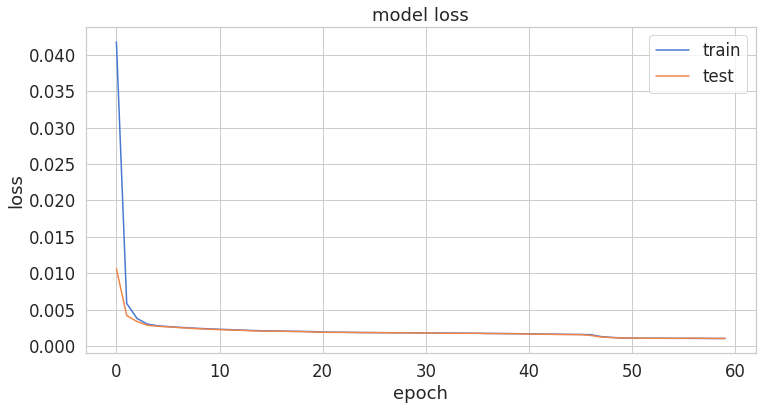

In [104]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [105]:
autoencoder = load_model(filename)
print(f'Min Loss:{np.min(history["loss"])}')

Min Loss:0.0010560028022155166


In [106]:
#get the MSE error term
predictions = autoencoder.predict(scaled_seqs)
mse = np.mean(np.power(scaled_seqs - predictions, 2), axis=1)
print('MSE:', np.quantile(mse, 0.999)) # => the 9999% quatile - only 0.0001% have error score higher than that

MSE: 0.004304660525741891


In [107]:

#encode all the data
encoded_seqs = encode_sequence_list(seqs_ds.iloc[:,0])
#scale it
scaled_data = MinMaxScaler().fit_transform(encoded_seqs)
#predict it
predicted = autoencoder.predict(scaled_data)
#get the error term
mse = np.mean(np.power(scaled_data - predicted, 2), axis=1)
#now add them to our data frame
seqs_ds['MSE'] = mse

In [108]:
display(seqs_ds)


,0,MSE
0,udaṅmukha,0.001576
1,hasantī,0.000578
2,nihākā,0.000395
3,dandahyamānognirgaṅg,0.004398
4,kośātakī,0.000156
...,...,...
66973,selvan,0.000261
66974,azhaghan,0.000546
66975,nanu,0.000558
66976,neenu,0.000895


In [109]:

mse_threshold = np.quantile(seqs_ds['MSE'], 0.9999)
print(f'MSE 0.9999 threshhold:{mse_threshold}')

MSE 0.9999 threshhold:0.0050601685556191135


In [110]:
seqs_ds['MSE_Outlier'] = 0
seqs_ds.loc[seqs_ds['MSE'] > mse_threshold, 'MSE_Outlier'] = 1

In [87]:
print(f"Num of MSE outlier:{seqs_ds['MSE_Outlier'].sum()}")

seqs_ds.loc[seqs_ds['MSE_Outlier'] == 1]

Num of MSE outlier:7


,0,MSE,MSE_Outlier
25095,mehagudāṅkurāni,0.005114,1
33886,ātmaśarīrendriy,0.005094,1
36467,adṛṣṭaśrutapūrv,0.005656,1
42923,rāmamantrānukīr,0.005609,1
46182,vrajānandinnand,0.006089,1
59510,kāminīndrendvād,0.005027,1
65991,pūrayediṣṭavālu,0.005147,1


In [111]:
print(f"Num of MSE outlier:{seqs_ds['MSE_Outlier'].sum()}")

seqs_ds.loc[seqs_ds['MSE_Outlier'] == 1]

Num of MSE outlier:7


,0,MSE,MSE_Outlier
15455,anavacchinnacidānand,0.006147,1
24953,aindrīndravāruṇīndrā,0.005379,1
33069,śakratarurnadīsarjor,0.005088,1
36619,anirvacanīyānandapra,0.005489,1
46182,vrajānandinnandīśvar,0.006075,1
54721,grāhyamathendukundad,0.005151,1
63323,sakalasuramunīndrair,0.005492,1
